# Co-Substrate Compensation & Integral Feedback

#### Soumya Kannan, April 15, 2016

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](cosubstrate_compensation.ipynb).*

In [4]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

### Chance scaling relationship

In 1965, Britton Chance and coworkers qualitatively identified that $K_{M}^{ETC}$ (the effective MM constant of ETC for oxygen) scales linearly with electron flux and inversely with the velocity constant of the terminal electron transfer reaction. Based on the Chance relationship, the mitochondrial ETC maintains homeostasis at a low $K_{M}^{ETC}$ - which corresponds to low oxygen concentration. Though this has been observed experimentally, it remained unclear for a long time how this could arise from a mechanistic level. Co-substrate compensation is a proposed metabolic control strategy for explaining the mechanism by which the Chance scaling relationship arises.

### One carrier ETC model  
  
Let's recall the one carrier electron transport chain model from class. Carrier $\mathrm{C}$ exists in two states: oxidized ($\mathrm{C}_0$) and reduced ($\mathrm{C}_1$). Oxidation is performed by enzyme $E_0$, which catalyzes this reaction with velocity $v_0$, and reduction is performed by enzyme $E_1$, which catalyzes the reaction with velocity $v_1$. 

![](ETC_Model.png)  
We saw that there was exact adaptation over a range of oxygen concentrations. This occurs because compensatory changes in the amount of the reduced carrier ($\mathrm{C}_1$ above) maintain oxygen homeostasis. The steady state of oxygen consumption rate is independent of $\mathrm{O}_2$ over a range of $[\mathrm{O}_2]$; amount of reduced carrier increases to compensate for reduced $[\mathrm{O}_2]$. 

### CSC intuition

Recall assumptions:  
> 1. One carrier, $\mathrm{C}$.
> 2. In the linear regime of $\mathrm{C}_1$, reactions are Michaelis-Menten.
> 3. $C_\mathrm{T} = [\mathrm{C}_{0}] + [\mathrm{C}_{1}]$ is constant.
  
The $\mathrm{O}_2$ consuming reaction ($E_0$) is intrinsically fast compared to the reduction ($E_1$) reaction. Thus, it is effectively less rate-limiting. Reducing $[\mathrm{O}_2]$ also reduces $v_0$, but this will lead to an increase in the reduced state $\mathrm{C}_1$, which compensates for the lower $[\mathrm{O}_2]$. We will further examine this intuition below as we analyze the robustness of this mechanism.

### But . . . is CSC robust to variations in enzyme parameters, kinetic parameters, etc?

Let's analyze! 
  
From our assumptions, we have  

\begin{align}
\frac{d[C_1]}{dt} &= v_1 - v_0 \\[1em]
v_0 &= \frac{k_{0}[C_{1}][O_{2}]}{[\mathrm{O}_2] + K_{M}^{0}} \\[1em]
v_1 &= \frac{k_{1}[C_{0}]}{[\mathrm{C}_0] + K_{M}^{1}} \\[1em]
C_\mathrm{T} &= [\mathrm{C}_0] + [\mathrm{C}_1],
\end{align}

where $K_{M}^{0}$ is the Michaelis-Menten constant of the $E_0$ reaction and $K_{M}^{1}$ is the Michaelis-Menten constant of the $E_1$ reaction.   
  
Now, let's define a measure of CSC-mediated homeostasis,
$$k_M = \frac{K_{M}^{ETC}}{K_{M}^{0}}.$$  
Here, $K_{M}^{ETC}$ is the concentration of $\mathrm{O}_2$ that generates a 50% reduction in consumption rate (effective Michaelis-Menten constant of $\mathrm{O}_2$), which we seek to derive an expression for in order to get $k_M$.  When $k_M$ is approximately 1, rate constancy is maintained only when $E_0$ is saturated, i.e. ($[\mathrm{O}_2] \gg K_{M}^{0}$). However, when $k_M \ll 1$, we can also get rate constancy even when $E_0$ is not saturated. The authors derive (in the supplemental material of the paper, if you are interested) the following dimensionless parameters that determine $k_M$  
  
$$\alpha = \frac{k_{0}C_\mathrm{T}}{k_1}$$  
$$\beta = \frac{K_{M}^{1}}{C_\mathrm{T}}.$$  
Here, $\alpha$ is the kinetic disparity; this basically means that it is a measure of the kinetic imbalance between the two enzymes. When $\alpha \gg 1$, $E_0$ is faster than $E_1$ and vice versa. $\beta$ is the $E_1$ dissociation constant. When $\beta \gg 1, E_1$ is not saturated even when the carrier only exists in the oxidized state, but when $\beta \ll 1, E_1$ is saturated even for a small amount of the carrier existing in the oxidized state.   
  
The expression for $k_M$ in terms of $\alpha$ and $\beta$ is as follows:  
$$k_M(\alpha, \beta) = \frac{c_{1}^{m}(2 - \alpha c_{1}^{m})}{4 - [2 + 2\alpha(1 + \beta)]c_{1}^{m} + \alpha(c_{1}^{m})^{2}},$$  
where  
$$c_{1}^{m}(\alpha, \beta) = \frac{1}{2}[(1 + \beta + 1 / \alpha) - \sqrt{(1 + \beta + 1 / \alpha)^2 - 4 / \alpha}].$$  
$c_{1}^{m}$ represents the fraction of the carrier substrate that is in the reduced state when $[\mathrm{O}_2]$ is maximal.  

As $[O_{2}] \rightarrow \infty$, we find the maximal rate of of ETC oxygen consumption at steady state to be:  
  
$$V_{max}^{ETC} = k_{0} C_\mathrm{T} c_{1}^{m} = \alpha k_{1} c_{1}^{m}$$  

Again, the derivation for all of this is in the supplement to the paper (found [here](http://www.cell.com/cms/attachment/2024910902/2044618105/mmc1.pdf)). 
  
What does this tell us about the robustness of CSC? Let's code it up!

In [5]:
# Define our functions
def c_1_m(a, b):
    '''
    Function to define $c^{1}_{m}$, the fraction of reduced
    carrier substrate at maximal oxygen concentration
    '''
    d = 1 + b + (1 / a)
    return (1 / 2) * (d - np.sqrt(d**2 - 4 / a))

def k_M(a, b):
    '''
    Function to define $k_M$, the ratio of the Michaelis-Menten 
    constant for oxygen to that of E0.
    '''
    c = c_1_m(a, b)
    num = c * (2 - a * c)
    denom = 4 - (2 + 2 * a * (1 + b)) * c + a * c**2
    return num / denom

We'll plot $k_M$ for a range of $\alpha$ and $\beta$ values. This will allow us to see the range of parameter space in which oxygen homeostasis can be maintained without saturation of $E_0$ (i.e. $k_M \ll 1$).

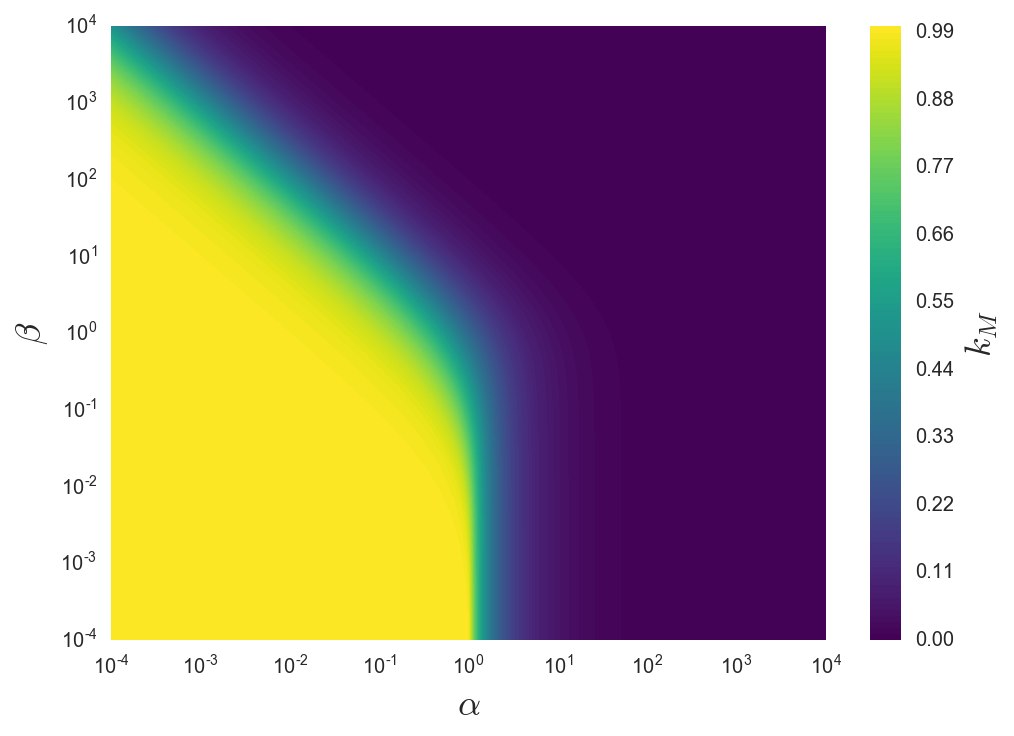

In [10]:
alpha = np.logspace(-4, 4, num=1000)
beta = np.logspace(-4, 4, num=1000)

# Grid it up for 2D plot
aa, bb = np.meshgrid(alpha, beta)

# Compute km
km = k_M(aa, bb)

# Generate plot
contplot = plt.contourf(aa, bb, km, 100, cmap='viridis',
                        vmin=0, vmax=1)
plt.xscale('log')
plt.yscale('log')
cbar = plt.colorbar(contplot)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
cbar.ax.set_ylabel(r'$k_M$');

All of that purple area is where $k_M \ll 1$; this is the range of parameters space in which CSC is robust to variation in the parameters. This plot shows us two important conditions in which CSC is robust:  
> 1. When $\alpha \gg 1$. This means that $E_0$ is faster than $E_1$ as $\alpha \gg 1$ implies $k_0 \mathrm{C}_\mathrm{T} \gg k_1$.
> 2. When $\alpha\beta \gg 1$. This means that the first order rate of carrier oxidation by $E_0$ is much larger than that of carrier reduction by $E_1$, as $\alpha\beta \gg 1$ implies $k_0 \gg k_1 / K_{M}^{1}$.  

Essentially, if the terminal electron transfer reaction is faster than the upstream transfer reaction, it is sufficient for CSC in our simple toy model of a single-carrier ETC. As it turns out, the robust CSC regime we found above is representative of the actual conditions observed in the mitochondrial ETC, so it seems likely that CSC is driving oxygen homeostasis in the mitchondrial ETC. 

### Back to the Chance relationship

So, were we able to recapitulate the Chance relationship? Let's consider the robust regime of CSC we just found above, where $\alpha >> 1$ or $\alpha >> 1 / \beta$ (i.e. $k_M << 1$). In this regime, we can reduce our expression for $k_{M}(\alpha, \beta)$ to:  
$$k_{M}(\alpha, \beta) = \frac{(2\beta + 1)}{2(\beta + 1)^{2}\alpha}$$  
Let $A = \frac{2\beta + 1}{2(\beta + 1)}$. Then, we have:  
$$k_{M}(\alpha, \beta) = A \frac{1}{\alpha (\beta + 1)} = A \frac{V_{max}^{ETC} K_{M}^{0}}{k_0}$$  
when $V_{max}^{ETC}$ and $K_{M}^{0}$ are similarly reduced using the constraints on $\alpha$ and $\beta$ in the robust regime.  
  
But...let's recall that $k_{M}(\alpha, \beta)$ is proportional to $K_{M}^{ETC}$, so thus we see that $K_{M}^{ETC}$ is directly proportional to $V_{max}^{ETC}$ and inversely proportional to $\frac{k_0}{K_{M}^{0}}$, which is the Chance relationship! So, CSC also agrees with previous observations and analysis, and in fact provides a mechanism by which to explain these observations.

### Approaching the homework problem: tips

Think about the following questions:
> 1. Write an ODE model for the ETC system, assuming Michaelis-Menten kinetics with respect to $[\mathrm{O}_2]$, first order with respect to carrier concentrations
> 2. What is the oxygen consumption rate in terms of $[C_1]$ and $[\mathrm{O}_2]$? What assumptions do you need to be able to eliminate $[C_1]$?
> 3. Now, given your expression for $[\mathrm{O}_2]$ consumption rate, how would you go about finding the maximal rate and the value of $[\mathrm{O}_2]$ at which the rate is half-maximal?
> 4. In problem 3.d.ii, you will need to show integral feedback, but it is simpler than the chemotaxis case (see below). How would you go about this?

### Some notes on integral feedback

Let's take a look at the robust model for chemotaxis.  
  
![](Chemotaxis.png)

Examining the active receptor state, let's define the following: 
$$X_{m}^{*} = A$$ 
$$X_{mt} = X_{m} + X_{m}^{*} = X_{m} + A$$   
$X_{mt}$ represents the total amount of methylated receptor and $A$ is the activity  
  
Let's assume CheB ($B$) acts in the linear regime. Then, we can write:  
$$\frac{dX_{mt}}{dt} = v_{R} R - v_{B} BA$$  
If we solve for steady state of activity ($A_{st}$) by setting the above derivative to 0, we find:  
$$A_{st} = \frac{v_{R} R}{v_{B} B}$$  
Substituting this back into our ODE, we get:  
$$\frac{dX_{mt}}{dt} = -v_{B} B(A - A_{st})$$  
Let's integrate this. Remember, $A$ and $A_{st}$ are both dependent on $X_{mt}$.
$$X_{mt} = X_{mt0} - v_{B} B \int (A - A_{st}) dt$$  
Now, let's define the rate constant of transition from $X_{m}$  to $X_{m}^{*}$ occurs with rate constant $k$ and the reverse transition occurs with rate constant $k'$. Then, from mass action, kinetics, we can write the ODE for $A$:  
$$\frac{dA}{dt} = k X_{m} - k' X_{m}^{*} - v_{B} BA$$  
$$ = k X_{mt} - (-k + k' + v_{B} B) A$$  
$$ = a X_{mt} - bA$$  
where $a = k$ and $b = -k + k' + v_{B} B$  
If we assume the system was at steady state before ligand was added, we can find the steady state (also the constant of integration) for $X_{mt}$ by setting the ODE for $A$ to 0. This gives us:  
$$X_{mt0} = \frac{bA_{st}}{a}$$  
Now, substituting our expression for $X_{mt}$ above into $dA / dt$, we have:  
$$\frac{dA}{dt} = a\frac{bA_{st}}{a} - av_{B} B \int (A - A_{st}) dt - bA$$  
$$ = -b(A - A_{st}) - av_{B} B \int (A - A_{st}) dt$$  
This allows us to reason about what happens to $dA / dt$ when $A$ is greater or lower than $A_{st}$.  
  
For example, let's consider when $A > A_{st}$ for a while. Then $X_{mt} < X_{mt0}$, and $dA / dt < 0$, so the amount of $A$ decreases. In general, as the gap between $A$ and $A_{st}$ decreases, so does the integral of error.

### References

Kueh, H., Niethammer, P., & Mitchison, T. (2013). Maintenance of Mitochondrial Oxygen Homeostasis by Cosubstrate Compensation. Biophysical Journal, 104(6), 1338-1348. doi:10.1016/j.bpj.2013.01.030  
The paper can be found [here](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3602778/).